In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from luc_crime_fncs import cleaner, gps_to_merc, find_all_address
from bokeh.plotting import figure, show, output_notebook, save, output_file
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import ColumnDataSource

In [4]:
# creating a sample DF of chicago crime dataset
originalPath = 'C:/Users/agarc/CrimeAnalyses/ChicagoCrime/DataSets/all_cimes_2022.csv'
starting_df = pd.read_csv(originalPath)

# n = 500
# starting_df = sampleDF(originalPath, n)

starting_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12713141,JF259485,1/1/2022 00:00,014XX S MUSEUM CAMPUS DR,870,THEFT,POCKET-PICKING,SPORTS ARENA / STADIUM,False,False,...,4.0,33,6,NaN,NaN,2022,6/5/2022 16:48,NaN,NaN,NaN
1,12871591,JF449106,1/1/2022 00:00,022XX N KEELER AVE,820,THEFT,$500 AND UNDER,RESIDENCE - PORCH / HALLWAY,False,False,...,35.0,20,6,NaN,NaN,2022,10/26/2022 16:52,NaN,NaN,NaN
2,12864747,JF440689,1/1/2022 00:00,007XX W FULTON MARKET,820,THEFT,$500 AND UNDER,POLICE FACILITY / VEHICLE PARKING LOT,False,False,...,42.0,28,6,NaN,NaN,2022,10/26/2022 16:52,NaN,NaN,NaN
3,12871564,JF449216,1/1/2022 00:00,049XX W HENDERSON ST,810,THEFT,OVER $500,STREET,False,False,...,31.0,15,6,NaN,NaN,2022,10/26/2022 16:52,NaN,NaN,NaN
4,12628303,JF156765,1/1/2022 00:00,061XX N HAMILTON AVE,2820,OTHER OFFENSE,TELEPHONE THREAT,APARTMENT,False,False,...,40.0,2,08A,NaN,NaN,2022,2/27/2022 15:48,NaN,NaN,NaN


In [5]:
# cleaning up column names; updates starting_df
cleaner(starting_df, lower=True, dropna=True)

# removes speficied columns
main_df = starting_df.drop(columns=['id', 'case_number', 'iucr', 'location_description', 'arrest',
                                    'domestic', 'ward', 'fbi_code', 'x_coordinate', 'y_coordinate',
                                    'beat', 'district', 'community_area', 'year', 'updated_on', 
                                    'latitude', 'longitude', 'date']) 
main_df.head()

print('main_df length:', len(main_df))

print(len(main_df['location'].value_counts())) # checking if mulitple crimes occur in at coords

main_df length: 232712
117418


In [6]:
# passing location val to gps_to_merc and populating new col with returned val
# anonymous fnc is needed as apply() only takes fncs invoked w/out parentheses

main_df['xCoords'] = main_df['location'].apply(lambda x : gps_to_merc(x)[0])
main_df['yCoords'] = main_df['location'].apply(lambda x : gps_to_merc(x)[1])
print(len(main_df))
main_df.head()

232712


,block,primary_type,description,location,xCoords,yCoords
7,012XX S KEELER AVE,HOMICIDE,FIRST DEGREE MURDER,"(41.865550441, -87.730046943)",-9.766064e+06,5.140861e+06
9,073XX S PHILLIPS AVE,CRIMINAL DAMAGE,TO PROPERTY,"(41.76196912, -87.564820445)",-9.747671e+06,5.125390e+06
10,069XX S LAFAYETTE AVE,CRIMINAL DAMAGE,TO PROPERTY,"(41.769070498, -87.626668445)",-9.754556e+06,5.126450e+06
11,008XX S CICERO AVE,BATTERY,SIMPLE,"(41.870042954, -87.744889046)",-9.767716e+06,5.141532e+06
12,076XX S STEWART AVE,BATTERY,DOMESTIC BATTERY SIMPLE,"(41.755368956, -87.634416245)",-9.755419e+06,5.124405e+06


In [7]:
# groups data by (location, primary_type, description) values and applies count fnc
crime_freq_by_coords = main_df.groupby(['location', 'primary_type', 'description']).count().reset_index()

# drop columns to avoid duplicate cols after merger in the next cell 
crime_freq_by_coords.drop(columns=['block', 
                                   'yCoords'], inplace=True)

# renames col for clairity
crime_freq_by_coords.rename(columns={'xCoords':'crime_freq'}, inplace=True)
print('crime_freq_by_coords length:', len(crime_freq_by_coords))
print('crime_freq sum:',crime_freq_by_coords['crime_freq'].sum())
crime_freq_by_coords.head()

crime_freq_by_coords length: 193667
crime_freq sum: 232712


,location,primary_type,description,crime_freq
0,"(36.619446395, -91.686565684)",DECEPTIVE PRACTICE,CREDIT CARD FRAUD,1
1,"(36.619446395, -91.686565684)",ROBBERY,STRONG ARM - NO WEAPON,1
2,"(41.644595158, -87.596781458)",BATTERY,DOMESTIC BATTERY SIMPLE,1
3,"(41.644608279, -87.613581972)",MOTOR VEHICLE THEFT,AUTOMOBILE,2
4,"(41.644608279, -87.613581972)",ROBBERY,AGGRAVATED VEHICULAR HIJACKING,1


In [8]:
# inner merge crime_freq_by_coords and main_df together on 3 column
crime_freq_df = pd.merge(main_df, crime_freq_by_coords, on=['location', 'primary_type', 'description'], how='inner')
crime_freq_df.drop_duplicates(subset=['location', 'primary_type', 'description'], inplace=True)
print('crime_freq_df length:', len(crime_freq_df))
print('crime_freq sum:', crime_freq_df['crime_freq'].sum())
crime_freq_df.head()

crime_freq_df length: 193667
crime_freq sum: 232712


,block,primary_type,description,location,xCoords,yCoords,crime_freq
0,012XX S KEELER AVE,HOMICIDE,FIRST DEGREE MURDER,"(41.865550441, -87.730046943)",-9.766064e+06,5.140861e+06,1
1,073XX S PHILLIPS AVE,CRIMINAL DAMAGE,TO PROPERTY,"(41.76196912, -87.564820445)",-9.747671e+06,5.125390e+06,1
2,069XX S LAFAYETTE AVE,CRIMINAL DAMAGE,TO PROPERTY,"(41.769070498, -87.626668445)",-9.754556e+06,5.126450e+06,1
3,008XX S CICERO AVE,BATTERY,SIMPLE,"(41.870042954, -87.744889046)",-9.767716e+06,5.141532e+06,1
4,076XX S STEWART AVE,BATTERY,DOMESTIC BATTERY SIMPLE,"(41.755368956, -87.634416245)",-9.755419e+06,5.124405e+06,1


In [9]:
# assigning glyph size based on crime_freq; if freq <= 17, then size is freq + 3;
# if freq > 17, then size is 30
glyph_sizes = [freq + 3 if freq <= 17 else 30 for freq in crime_freq_df['crime_freq']]

# make new df for map
for_bokeh_df = crime_freq_df.copy()

for_bokeh_df['glyph_size'] = glyph_sizes # new col for glyph sizes
for_bokeh_df.head()

,block,primary_type,description,location,xCoords,yCoords,crime_freq,glyph_size
0,012XX S KEELER AVE,HOMICIDE,FIRST DEGREE MURDER,"(41.865550441, -87.730046943)",-9.766064e+06,5.140861e+06,1,4
1,073XX S PHILLIPS AVE,CRIMINAL DAMAGE,TO PROPERTY,"(41.76196912, -87.564820445)",-9.747671e+06,5.125390e+06,1,4
2,069XX S LAFAYETTE AVE,CRIMINAL DAMAGE,TO PROPERTY,"(41.769070498, -87.626668445)",-9.754556e+06,5.126450e+06,1,4
3,008XX S CICERO AVE,BATTERY,SIMPLE,"(41.870042954, -87.744889046)",-9.767716e+06,5.141532e+06,1,4
4,076XX S STEWART AVE,BATTERY,DOMESTIC BATTERY SIMPLE,"(41.755368956, -87.634416245)",-9.755419e+06,5.124405e+06,1,4


In [10]:
# north/south bound streets with home number between 56XX to 72XX
northStreets = ['N KENMORE AVE', 'N WINTHROP AVE', 'N ARTHUR AVE', 'N SHERIDAN RD', 
                'N LAKEWOOD AVE', 'N MAGNOLIA AVE', 'N GLENWOOD AVE', 'N NEWGARD AVE'
                'N GREENVIEW AVE', 'N BOSWORTH AVE', 'N ASHLAND AVE', 'N CLARK ST',
                'N RAVENSWOOD AVE', 'N RIDGE AVE', 'N RIDGE BLVD', 'N WOLCOTT AVE', 
                'N WAYNE AVE', 'N BROADWAY', 'N PAULINA ST', 'N HERMITAGE AVE', 
                'N DAMEN']

# west/east bound streets with home number less than or equal to 19XX
westStreets = ['W LOYOLA AVE', 'W SHERIDAN RD', 'W ROSEMONT AVE', 'W GRANVILLE AVE',
               'W ALBION AVE', 'W NORTH SHORE AVE', 'NEIL HARTIGAN AVE', 'W COLUMBIA AVE', 
               'W PRATT BLVD', 'W FARWELL AVE', 'W MORSE AVE', 'W LUNT AVE', 
               'W GREENLEAF AVE', 'W ESTES AVE', 'W TOUHY AVE', 'W CHASE AVE', 
               'W GLENLAKE AVE', 'W THORNDALE AVE', 'W ARDMORE AVE', 'W HOLLYWOOD AVE',
               'W BRYN MAWR AVE', 'W VICTORIA ST', 'W EARLY AVE', 'W OLIVE AVE',
               'W DEVON AVE', 'W HIGHLAND AVE', 'W THOME AVE', 'W SCHREIBER', 
               'W WALLEN AVE', 'W HOOD AVE', 'W NORWOOD AVE']

# list of addresses around LUC where crimes occurred
luc_addresses = find_all_address(crime_freq_df, addressCol='block', horiSt=westStreets, vertSt=northStreets)

# makes DF of bool values indicating whether a luc_addresses item is in a given cell
bool_df = for_bokeh_df.isin(luc_addresses)

# adds new column, is_by_luc to for_bokeh_df_copy
for_bokeh_df['is_by_luc'] = bool_df['block']

# makes new DF, luc_crime_df, which contains only rows that have True as value for is_by_luc

for_bokeh_df = for_bokeh_df[for_bokeh_df['is_by_luc'] == True]
for_bokeh_df.head()

,block,primary_type,description,location,xCoords,yCoords,crime_freq,glyph_size,is_by_luc
212,070XX N SHERIDAN RD,CRIMINAL DAMAGE,TO VEHICLE,"(42.010704854, -87.662584365)",-9.758554e+06,5.162583e+06,2,5,True
297,066XX N ASHLAND AVE,CRIMINAL DAMAGE,TO PROPERTY,"(42.002216434, -87.670502661)",-9.759436e+06,5.161311e+06,1,4,True
547,016XX W MORSE AVE,ASSAULT,SIMPLE,"(42.007820806, -87.671106782)",-9.759503e+06,5.162151e+06,1,4,True
560,069XX N RIDGE BLVD,DECEPTIVE PRACTICE,FORGERY,"(42.00817416, -87.681541713)",-9.760665e+06,5.162204e+06,1,4,True
594,058XX N SHERIDAN RD,STALKING,SIMPLE,"(41.987951293, -87.655323262)",-9.757746e+06,5.159175e+06,2,5,True


In [11]:
# used to pass into bokeh ColumnDataSource class which contains
# map's structure parameters including coords and glyph properties

cds_dict = {'xAxis':list(for_bokeh_df['xCoords']), 
            'yAxis':list(for_bokeh_df['yCoords']), 
            'PrimaryDescription':list(for_bokeh_df['primary_type']),
            'SecondaryDescription':list(for_bokeh_df['description']),
            'Freq':list(for_bokeh_df['crime_freq']), 
            'circleSize':list(for_bokeh_df['glyph_size']), 
            'Location':list(for_bokeh_df['location']), 
            'Block':list(for_bokeh_df['block'])}

# instantiating bokeh class
source = ColumnDataSource(data=cds_dict)

# this is how to choose the info that is displayed when hovering over glyph
hoverTool = [('Crime Type', '@PrimaryDescription'), ('Specific Type', '@SecondaryDescription'), 
             ('Frequency', '@Freq' ), ('Block', '@Block'), ('-----------','')]

# generates Bokeh Figure
p = figure(x_axis_type = 'mercator', y_axis_type = 'mercator', tooltips=hoverTool)

# retrieves an instance of a tile provider
map_provider = get_provider(Vendors.CARTODBPOSITRON)

# adds the chosen tile provider to the plot.
p.add_tile(map_provider)

# creates glyphs on the plot and is used for customizing them
p.circle(x='xAxis', y='yAxis', source=source, 
         size='circleSize', fill_alpha= 0.20, 
         line_color='red', fill_color='red')

# Give output filepath
outfp = "/Users/agarc/CrimeAnalyses/ChicagoCrime/InteractivePlots/luc_crime_map.html"

# Save the plot by passing the plot -object and output path
# save(obj=p, filename=outfp)

# output_notebook()
output_file('map.html')
show(p)

In [12]:
# makes df with crime type frequency
crime_count_df = for_bokeh_df['primary_type'].value_counts().reset_index(name='frequency')
print('Crime Total:', crime_count_df['frequency'].sum())
crime_count_df.head()

Crime Total: 3333


,index,frequency
0,THEFT,874
1,BATTERY,517
2,CRIMINAL DAMAGE,369
3,ASSAULT,293
4,MOTOR VEHICLE THEFT,265


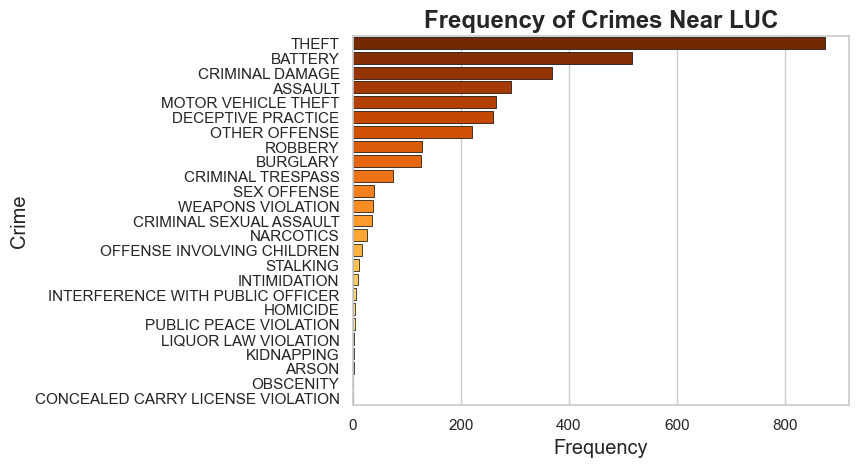

In [13]:
# sets background of graph
sns.set_theme(style='whitegrid', palette='pastel')

# creates default bar graph based on given arguments
bar_graph = sns.barplot(y='index', x='frequency', data=crime_count_df, 
                        edgecolor='black', linewidth=.5, saturation=4,
                        palette='YlOrBr_r')

# following 3 lines change the axes names adds title
bar_graph.set_xlabel('Frequency', size='large')
bar_graph.set_ylabel('Crime', size='large')
bar_graph.set_title('Frequency of Crimes Near LUC', weight='bold', size='x-large') # make bold and x-large

# increases resolution of graph
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.show()

In [15]:
# save freq graph
bar_plot_fig = bar_graph.get_figure()

# bbox_inches adjust crop of picture
bar_plot_fig.savefig('C:/Users/agarc/CrimeAnalyses/ChicagoCrime/plots/crime_freq_plot.png', bbox_inches="tight")